<a href="https://colab.research.google.com/github/Ramkanc/Capstone_flickr30K/blob/main/Capstone1_V2__MultiModal_Similarity30k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [9]:
file_id1 = 'https://drive.google.com/uc?export=download&id=17icNB_CL7CKP-k3vn0reBpWmrzLb25fn'
!wget --no-check-certificate -O txt_embedding.zip "{file_id1}"

--2024-12-13 02:54:11--  https://drive.google.com/uc?export=download&id=17icNB_CL7CKP-k3vn0reBpWmrzLb25fn
Resolving drive.google.com (drive.google.com)... 64.233.187.101, 64.233.187.139, 64.233.187.138, ...
Connecting to drive.google.com (drive.google.com)|64.233.187.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=17icNB_CL7CKP-k3vn0reBpWmrzLb25fn&export=download [following]
--2024-12-13 02:54:12--  https://drive.usercontent.google.com/download?id=17icNB_CL7CKP-k3vn0reBpWmrzLb25fn&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.187.132, 2404:6800:4008:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.187.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2429 (2.4K) [text/html]
Saving to: ‘txt_embedding.zip’

txt_embedding.zip   100%[===================>]   2.37K  --.-KB/s    in 0s      

In [10]:
file_id2 = 'https://drive.google.com/uc?export=download&id=1IA76FH2ks65AtjCUCoa52fJ7vlNGuLua'
!wget --no-check-certificate -O txt_embedding.zip "{file_id2}"

--2024-12-13 02:54:30--  https://drive.google.com/uc?export=download&id=1IA76FH2ks65AtjCUCoa52fJ7vlNGuLua
Resolving drive.google.com (drive.google.com)... 64.233.187.101, 64.233.187.139, 64.233.187.138, ...
Connecting to drive.google.com (drive.google.com)|64.233.187.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1IA76FH2ks65AtjCUCoa52fJ7vlNGuLua&export=download [following]
--2024-12-13 02:54:31--  https://drive.usercontent.google.com/download?id=1IA76FH2ks65AtjCUCoa52fJ7vlNGuLua&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.187.132, 2404:6800:4008:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.187.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428 (2.4K) [text/html]
Saving to: ‘txt_embedding.zip’

txt_embedding.zip   100%[===================>]   2.37K  --.-KB/s    in 0s      

In [11]:
# Define the folder paths
img_embedding_folder = "img_embedding"
txt_embedding_folder = "txt_embedding"

# Check if the folders exist, and create them if they don't
if not os.path.exists(img_embedding_folder):
  os.makedirs(img_embedding_folder)
  print(f"Folder '{img_embedding_folder}' created.")
else:
  print(f"Folder '{img_embedding_folder}' already exists.")

if not os.path.exists(txt_embedding_folder):
  os.makedirs(txt_embedding_folder)
  print(f"Folder '{txt_embedding_folder}' created.")
else:
  print(f"Folder '{txt_embedding_folder}' already exists.")

Folder 'img_embedding' already exists.
Folder 'txt_embedding' already exists.


In [12]:
!unzip /content/img_embedding.zip -d /content/img_embedding

Archive:  /content/img_embedding.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/img_embedding.zip or
        /content/img_embedding.zip.zip, and cannot find /content/img_embedding.zip.ZIP, period.


In [13]:
!unzip /content/txt_embedding.zip -d /content/txt_embedding

Archive:  /content/txt_embedding.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/txt_embedding.zip or
        /content/txt_embedding.zip.zip, and cannot find /content/txt_embedding.zip.ZIP, period.


In [5]:
import gdown
file_id1 = 'https://drive.google.com/file/d/17icNB_CL7CKP-k3vn0reBpWmrzLb25fn/view?usp=drive_link'
out_file1 = 'txt_embedding.zip'
gdown.download(file_id1, out_file1, quiet=False)

file_id2 = 'https://drive.google.com/file/d/1IA76FH2ks65AtjCUCoa52fJ7vlNGuLua/'
out_file2 = 'img_embedding.zip'
gdown.download(file_id2, out_file2, quiet=False)

Downloading...
From: https://drive.google.com/file/d/17icNB_CL7CKP-k3vn0reBpWmrzLb25fn/
To: /content/txt_embedding.zip
92.0kB [00:00, 2.60MB/s]
Downloading...
From: https://drive.google.com/file/d/1IA76FH2ks65AtjCUCoa52fJ7vlNGuLua/
To: /content/img_embedding.zip
91.9kB [00:00, 2.38MB/s]


'img_embedding.zip'

In [ ]:
import shutil
# Import necessary libraries
#import patoolib
import os

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

# Install patool (if not already installed)
#!pip install patool==1.12

Mounted at /content/drive


In [ ]:
# Specify the path to the zip file in your Google Drive
source_folder1 = '/content/img_embedding.zip'
source_folder2 = '/content/txt_embedding.zip' # Replace with your file path

destination_folder = '/content/'  # This is the Colab content folder

# Copy the file
shutil.copy(source_folder1, destination_folder)#, dirs_exist_ok=True)
print(f'Folder copied to {destination_folder}')

shutil.copy(source_folder2, destination_folder)#, dirs_exist_ok=True)
print(f'Folder copied to {destination_folder}')

Folder copied to /content/
Folder copied to /content/


In [ ]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import re
import pickle

In [ ]:
class EmbeddingDataset(Dataset):
    def __init__(self, img_dir, txt_dir):
        """
        Args:
            img_dir (str): Path to the directory containing image embeddings (.pt files).
            txt_dir (str): Path to the directory containing text embeddings (.pt files).
        """
        self.img_dir = img_dir
        self.txt_dir = txt_dir

        # Load all image embedding filenames
        self.image_files = [
            f for f in os.listdir(img_dir) if f.endswith('.pt')
        ]

        # Ensure corresponding text embeddings exist
        self.dataset = []
        for img_file in self.image_files:
            base_name = os.path.splitext(img_file)[0]
            for suffix in range(1, 6):  # Assuming suffix ranges from 1 to 5
                txt_file = f"{base_name}_{suffix}.pt"
                txt_path = os.path.join(txt_dir, txt_file)
                if os.path.exists(txt_path):
                    self.dataset.append((os.path.join(img_dir, img_file), txt_path))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, txt_path = self.dataset[idx]

        # Load image embedding
        img_tensor = torch.load(img_path, weights_only=True)

        # Load text embedding
        txt_tensor = torch.load(txt_path, weights_only=True)

        return img_tensor, txt_tensor

In [ ]:
image_directory = '/content/img_embedding'
text_directory = '/content/txt_embedding'

In [ ]:
dataset_instance = EmbeddingDataset(image_directory, text_directory)

In [ ]:
print(f"Total samples in the dataset: {len(dataset_instance)}")

Total samples in the dataset: 158915


In [ ]:
# Access a sample
img_tensor, txt_tensor = dataset_instance[0]
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Text tensor shape: {txt_tensor.shape}")

Image tensor shape: torch.Size([1, 512])
Text tensor shape: torch.Size([1, 512])


In [ ]:
for i in range(3):  # Display the first 3 samples
    img_tensor, txt_tensor = dataset_instance[i]
    print(f"Sample {i + 1}:")
    print(f"Image Tensor Shape: {img_tensor.shape}")
    print(f"Text Tensor Shape: {txt_tensor.shape}")


Sample 1:
Image Tensor Shape: torch.Size([1, 512])
Text Tensor Shape: torch.Size([1, 512])
Sample 2:
Image Tensor Shape: torch.Size([1, 512])
Text Tensor Shape: torch.Size([1, 512])
Sample 3:
Image Tensor Shape: torch.Size([1, 512])
Text Tensor Shape: torch.Size([1, 512])


In [ ]:
# Create a DataLoader
batch_size = 35
dataloader = DataLoader(dataset_instance, batch_size=batch_size, shuffle=True)

# Iterate through DataLoader
for batch_idx, (img_batch, txt_batch) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Image Batch Shape: {img_batch.shape}")
    print(f"Text Batch Shape: {txt_batch.shape}")
    break  # Display only the first batch

Batch 1:
Image Batch Shape: torch.Size([35, 1, 512])
Text Batch Shape: torch.Size([35, 1, 512])


In [ ]:
# Initialize counters for global accuracy calculation
total_correct = 0
total_samples = 0

# Process all batches
for batch_idx, (img_batch, txt_batch) in enumerate(dataloader):
    # Move batches to the same device
    img_batch = img_batch.to(device)
    txt_batch = txt_batch.to(device)

    # Get the actual batch size for the current batch (could be smaller than 35 for the last batch)
    current_batch_size = img_batch.size(0)

    # Reduce dimensions via mean pooling
    img_reduced = img_batch.mean(dim=1)  # Shape: [current_batch_size, embedding_dim]
    txt_reduced = txt_batch.mean(dim=1)  # Shape: [current_batch_size, embedding_dim]

    # Normalize embeddings for cosine similarity
    img_norm = F.normalize(img_reduced, p=2, dim=1)  # Normalize image embeddings
    txt_norm = F.normalize(txt_reduced, p=2, dim=1)  # Normalize text embeddings

    # Compute similarity matrix (cosine similarity)
    similarity_matrix = torch.mm(img_norm, txt_norm.t())  # Shape: [current_batch_size, current_batch_size]

    # Find the most similar text embedding for each image embedding
    most_similar_idx = torch.argmax(similarity_matrix, dim=1)  # Shape: [current_batch_size]

    # Calculate accuracy
    ground_truth = torch.arange(current_batch_size, device=device)  # [0, 1, 2, ..., current_batch_size - 1]
    correct_predictions = (most_similar_idx == ground_truth).sum().item()
    total_correct += correct_predictions
    total_samples += current_batch_size

    batch_accuracy = correct_predictions / current_batch_size * 100  # Accuracy for this batch
    print(f"Batch {batch_idx + 1}:")
    #print(f"  Similarity Matrix: \n{similarity_matrix}")
    print(f"  Predicted Indices: {most_similar_idx}")
    print(f"  Ground Truth: {ground_truth}")
    print(f"  Accuracy: {batch_accuracy:.2f}%")

# Global accuracy
global_accuracy = total_correct / total_samples * 100
print(f"\nOverall Accuracy: {global_accuracy:.2f}%")


Streaming output truncated to the last 5000 lines.
Batch 3917:
  Predicted Indices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 16, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23,  2, 25,  2, 27, 28, 29, 30, 31, 32, 33, 34],
       device='cuda:0')
  Ground Truth: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
       device='cuda:0')
  Accuracy: 91.43%
Batch 3918:
  Predicted Indices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 32, 15, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 19, 28, 29, 18, 31, 32, 33, 34],
       device='cuda:0')
  Ground Truth: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
       device='cuda:0')
  Accuracy: 88.57%
Batch 3919:
  Predicted Indices: tensor([ 0,  1, 32,  4,  4,  5,  6,  7,  8,  9, 10, 11, 

In [ ]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
print (device)

cuda


In [ ]:
# Load image embeddings from the folder `img_embedding`
img_embedding_folder = 'img_embedding'
image_embeddings = []
image_paths = []

In [ ]:
# Load all the embeddings from .pt files in the folder
for filename in os.listdir(img_embedding_folder):
    if filename.endswith(".pt"):
        # Construct the full file path
        file_path = os.path.join(img_embedding_folder, filename)

        # Load the embedding from the .pt file
        embedding = torch.load(file_path, weights_only=True)  # Shape: [embedding_dim]

        # Assuming the filename (without extension) is the image name
        image_name = filename.split('.')[0]  # Remove .pt extension to get image name

        # Append the embedding and image path to the lists
        image_embeddings.append(embedding)
        image_paths.append(image_name)

# Convert the list of embeddings to a tensor and move to the same device
image_embeddings = torch.stack(image_embeddings).to(device)  # Shape: [num_images, embedding_dim]
image_embeddings = image_embeddings.squeeze(1)

# Normalize image embeddings
image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

In [ ]:
print(f"Image Embeddings Shape: {image_embeddings.shape}")
print(f"Image Paths: {image_paths}")

Image Embeddings Shape: torch.Size([31783, 512])
Image Paths: ['5349069500', '2545723691', '3560726559', '2998504949', '1873704867', '357870895', '4692195233', '4817644923', '1363345475', '4209180917', '2808098783', '5218106811', '2456675104', '7024548103', '175400432', '2994985669', '287967163', '418583100', '2248974479', '4268831069', '1021293940', '3025093', '1266359954', '6893218038', '2474115124', '6589857247', '457945610', '289639811', '4377027216', '3281611946', '3524914023', '2975253472', '4690243307', '3450874870', '1869706826', '3030565991', '2420457108', '2938181762', '5658127907', '3147913471', '3290105461', '1296412797', '158093226', '475739062', '4842411522', '2390134107', '7436121372', '1626754053', '2443938628', '4906687225', '6867197342', '111908743', '400851260', '2667092132', '6315352509', '4715038539', '3505657604', '5287405', '4601533921', '2498093487', '475073313', '3641022607', '4637943700', '4976246643', '867204263', '3720366614', '6338704', '174056037', '405651

In [ ]:
def retrieve_image_from_text(text_query):
    # Encode the text query
    text_inputs = processor(text=[text_query], return_tensors="pt", padding=True).to(device)#, truncation=True)

    # Extract text embeddings
    with torch.no_grad():
      text_embeddings = model.get_text_features(**text_inputs)

    # Normalize text embeddings
    text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True).to(device)

    print(f"Text Query: {text_query}")
    print(f"Text Embeddings Shape: {text_embeddings.shape}")

    # Ensure that text embeddings are 2D and image embeddings are 2D
    # if text_embeddings.dim() == 1:
    #     text_embeddings = text_embeddings.unsqueeze(0)  # Make it [1, embedding_dim]
    # Ensure that text and image embeddings are on the same device


    # Calculate cosine similarity between the text and image embeddings
    similarity_scores = torch.mm(text_embeddings, image_embeddings.T)  # Shape: [1, num_images]

    # Get the index of the most similar image
    most_similar_idx = torch.argmax(similarity_scores, dim=1).item()

    # Retrieve the corresponding image path
    retrieved_image_name = image_paths[most_similar_idx]
    retrieved_score = similarity_scores[0][most_similar_idx].item()

    return retrieved_image_name, retrieved_score

In [ ]:
!kaggle datasets download -d eeshawn/flickr30k
!unzip flickr30k.zip

Dataset URL: https://www.kaggle.com/datasets/eeshawn/flickr30k
License(s): other
flickr30k.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  flickr30k.zip
replace captions.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [ ]:
# Example usage
text_query = "Two men working on a machine wearing hard hats ."
best_image_name, similarity_score = retrieve_image_from_text(text_query)
print(f"Retrieved Image: {best_image_name}, Similarity Score: {similarity_score}")

Text Query: Two men working on a machine wearing hard hats .
Text Embeddings Shape: torch.Size([1, 512])
Retrieved Image: 4153903524, Similarity Score: 0.3432527184486389


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

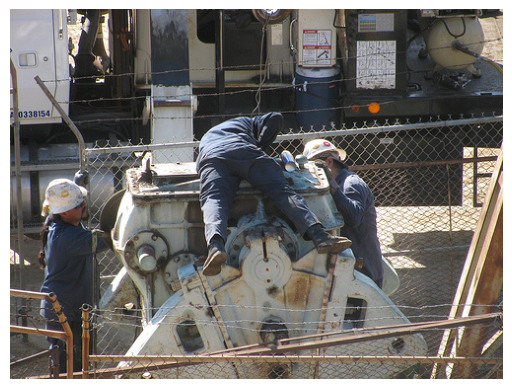

In [ ]:
im_path = f"/content/flickr30k_images/{best_image_name}.jpg"
img = Image.open(im_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
caption_embedding_folder = 'txt_embedding'
caption_embeddings_lst = []
captions_lst = []

In [ ]:
for filename in os.listdir(caption_embedding_folder):
    if filename.endswith(".pt"):
        file_path = os.path.join(caption_embedding_folder, filename)
        embedding = torch.load(file_path, weights_only=True).to(device)
        embedding = embedding / embedding.norm(p=2, dim=-1, keepdim=True)
        caption_embeddings_lst.append(embedding)
        captions_lst.append(filename)

In [ ]:
captions_file = "/content/captions.txt"
def extract_third_part(caption_heading):
    """
    Opens a file, finds a specific line, splits it, and returns the third part.


    Args:
        filename (str): The name of the file to open. Defaults to "captions.txt".

    Returns:
        str: The third part of the split line, or None if the line is not found.
    """
    #filename = os.path.join("/content/",{filename})
    caption_heading = caption_heading.split(".")[0]
    caption_heading = caption_heading.replace("_", ".jpg,")
    print(f"Caption index is : {caption_heading}")
    try:
        with open(captions_file, "r") as file:  # Open the file in read-only mode
            for line in file:  # Iterate through each line
                if caption_heading in line:  # Check if the line contains the target phrase
                    parts = line.strip().split(",")  # Split the line by commas
                    if len(parts) >= 3:  # Ensure there are at least 3 parts
                        return parts[2]  # Return the third part
                    else:
                        print("Line does not have 3 parts after splitting.")
                        return None
            print("Line containing 'best_caption_idx' not found in the file.")
            return None  # Return None if the line is not found
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
        return None

# Example usage
# result = extract_third_part("3660303751_4.pt")
# if result:
#     print(f"The third part is: {result}")

In [ ]:
# Assuming you're using CLIP to extract features and define a set of captions
def generate_caption_from_image(image_path):

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt", padding=True).to(device)

    # Extract image features
    with torch.no_grad():
        image_embed = model.get_image_features(**inputs)
    # Normalize the embeddings
    image_embed = image_embed / image_embed.norm(p=2, dim=-1, keepdim=True).to(device)
    #print(f"Image Embeddings Shape: {image_embed.shape}")

    # Caption embeddings to tensors
    caption_embeddings_stk = torch.stack(caption_embeddings_lst).to(device)
    caption_embeddings_stk = caption_embeddings_stk.squeeze(1)
    #print(f"Caption Embeddings Shape: {caption_embeddings_stk.shape}")


    # Compute similarity scores (cosine similarity)
    similarity_scores = torch.mm(image_embed, caption_embeddings_stk.T)  # Shape: [1, num_templates]
    best_caption_idx = torch.argmax(similarity_scores, dim=1).item()
    print(f"Best Similarity score is : ", torch.argmax(similarity_scores, dim=1))

    extracted_caption = extract_third_part(captions_lst[best_caption_idx])
    #print(f"Extracted Caption: {extracted_caption}")

    # Return the best caption for the image
    return extracted_caption

Best Similarity score is :  tensor([110439], device='cuda:0')
Caption index is : 3660303751.jpg,4
Generated Caption: A man is sitting in a harness and washing a window .


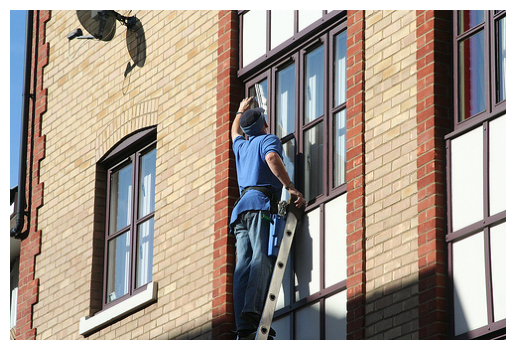

In [ ]:
# Example usage
image_path = "/content/flickr30k_images/1000344755.jpg"
caption = generate_caption_from_image(image_path)
print(f"Generated Caption: {caption}")
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()